# Pneumonia Diagnosis from chest X-ray

CNN classiffication with Keras.  
Diagnose pneumonia from chest x-ray

## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation, Dropout

import matplotlib.pyplot as plt
import seaborn as sn

# custom finction to split the data
from utils.data_prep import train_val_split

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

## Create Image Data Generator from directory

In [2]:
# Create a new validation dirctory 
train_val_split(0.1)

new validation directory with 0.10 of training data in C:\Users\leoni\PycharmProjects\Data\Post_ETL\chest_xray_V2\val_v2


In [3]:
# Data path
# replace data path with inpu from yml file!
data_path = r"C:\Users\leoni\PycharmProjects\Data\Post_ETL"
PATH = os.path.join(data_path, "chest_xray_V2")
print(os.listdir(PATH))

['test', 'train', 'val', 'val_v2']


In [4]:
# train, validate, test dirs
train_dir = os.path.join(PATH, "train")
val_dir = os.path.join(PATH, "val_v2")
test_dir = os.path.join(PATH, "test")

for d in train_dir, test_dir, val_dir:
    print(os.listdir(d))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


In [5]:
# train
pneum_train_dir = os.path.join(train_dir, 'PNEUMONIA')
norm_train_dir = os.path.join(train_dir, 'NORMAL')

#val (move data into train dir and use validation splits)
pneum_val_dir = os.path.join(val_dir, 'PNEUMONIA')
norm_val_dir = os.path.join(val_dir, 'NORMAL')

# test
pneum_test_dir = os.path.join(test_dir, 'PNEUMONIA')
norm_test_dir = os.path.join(test_dir, 'NORMAL')

In [6]:
data_dict = {'pneum_train': len(os.listdir(pneum_train_dir)),
             'norm_train': len(os.listdir(norm_train_dir)),
             'pneum_val': len(os.listdir(pneum_val_dir)),
             'norm_val': len(os.listdir(norm_val_dir)),
             'pneum_test': len(os.listdir(pneum_test_dir)),
             'norm_test': len(os.listdir(norm_test_dir))
            }

print(data_dict)

{'pneum_train': 3523, 'norm_train': 1219, 'pneum_val': 352, 'norm_val': 122, 'pneum_test': 390, 'norm_test': 234}


In [7]:
params = {'batch_size': 256,
          'epochs': 30,
          'img_h': 256,
          'img_w': 256
         }

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
val_image_generator = ImageDataGenerator(rescale=1./255)
# train_image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [9]:
print("class is %s" % train_image_generator.__class__)
print("parent class is %s" % train_image_generator.__class__.__base__)

class is <class 'tensorflow.python.keras.preprocessing.image.ImageDataGenerator'>
parent class is <class 'keras_preprocessing.image.image_data_generator.ImageDataGenerator'>


In [10]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary')

val_data_gen = val_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=val_dir,
                                                          shuffle=True,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary')

Found 4742 images belonging to 2 classes.
Found 474 images belonging to 2 classes.


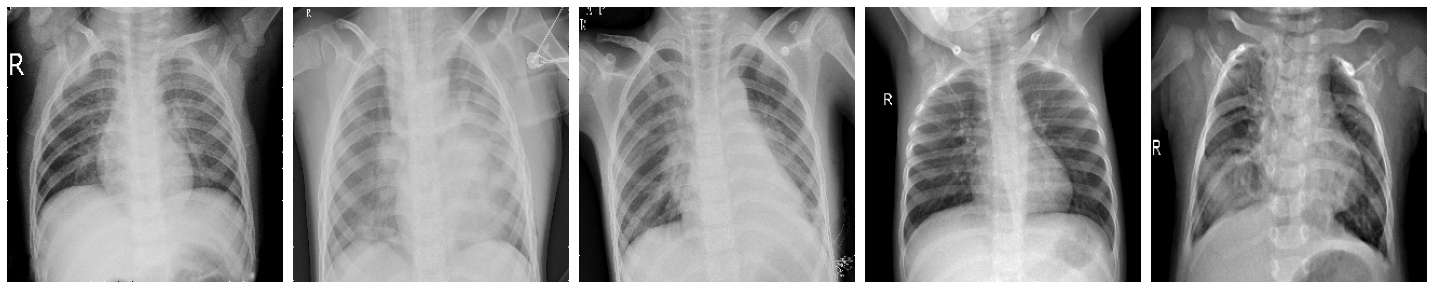

In [11]:
sample_training_images, _ = next(train_data_gen)
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
# from https://www.tensorflow.org/tutorials/images/classification
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        # show grayscale image
        ax.imshow(img[:,:,0], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    fig.savefig(r"images/xray_sample.png", format="png")
plotImages(sample_training_images[:5])

## Simple CNN (with dropout)

In [12]:
# Architecture
# Should we add the final activation or not? # Activation('sigmoid')
# cnn_1 = tf.keras.models.load_model('cnn_1.h5')
cnn_1 = Sequential([Conv2D(filters=16, kernel_size=4, strides=(1, 1), padding='same', activation='relu',
                          input_shape=(params['img_h'], params['img_w'], 1)),
                    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    Conv2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
                    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
                    Conv2D(filters=64, kernel_size=2, strides=(1, 1), padding='same', activation='relu'),
                    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='valid'),
                    Flatten(),
                    Dropout(rate=0.5),
                    Dense(units=512, activation='relu'),
                    Dense(units=512, activation='relu'),
                    Dense(units=1),
                   ])

In [13]:
#cnn_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# if sigmoind activation is used in the model
cnn_1.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

print(cnn_1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

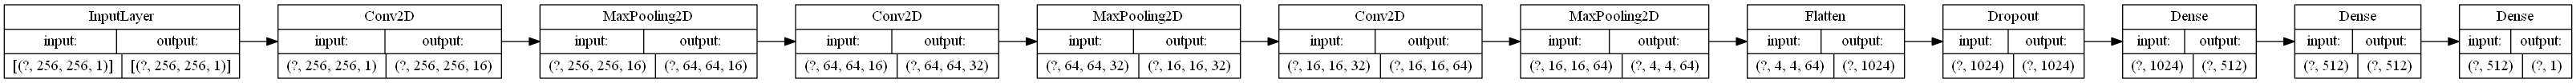

In [14]:
# Plot model
tf.keras.utils.plot_model(cnn_1, to_file=r"images/cnn_dropout.png", rankdir='LR', show_layer_names=False, show_shapes=True)

In [15]:
history = cnn_1.fit_generator(train_data_gen,
                              steps_per_epoch=len(train_data_gen),
                              epochs=params['epochs'],
                              validation_data=val_data_gen,
                              validation_steps=len(val_data_gen)
                             )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 2 steps
Epoch 1/30
19/19 [==============================] - 35s 2s/step - loss: 0.4971 - accuracy: 0.7543 - val_loss: 0.3108 - val_accuracy: 0.8608
Epoch 2/30
19/19 [==============================] - 31s 2s/step - loss: 0.2522 - accuracy: 0.8855 - val_loss: 0.1592 - val_accuracy: 0.9325
Epoch 3/30
19/19 [==============================] - 30s 2s/step - loss: 0.1912 - accuracy: 0.9184 - val_loss: 0.1599 - val_accuracy: 0.9177
Epoch 4/30
19/19 [==============================] - 30s 2s/step - loss: 0.1404 - accuracy: 0.9447 - val_loss: 0.1314 - val_accuracy: 0.9430
Epoch 5/30
19/19 [==============================] - 30s 2s/step - loss: 0.1362 - accuracy: 0.9416 - val_loss: 0.1113 - val_accuracy: 0.9726
Epoch 6/30
19/19 [==============================] - 30s 2s/step - loss: 0.1159 - accuracy: 0.9555 - val_loss: 0.1047 - val_accuracy: 

In [16]:
cnn_1.save('cnn_1.h5')

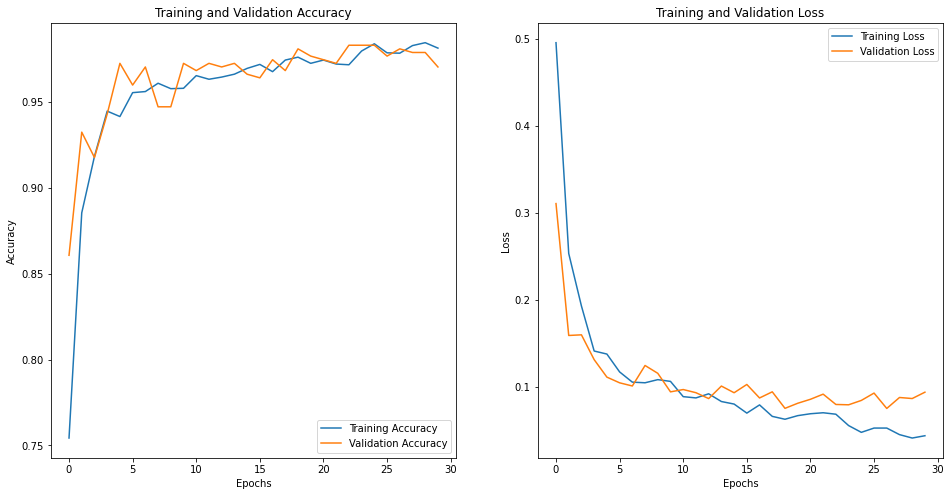

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(params['epochs'])

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
fig.savefig(r"images/Epochs_acc_and_loss.png", format="png")

In [18]:
cnn_1 = tf.keras.models.load_model('cnn_1.h5')

In [19]:
# Quickfix for the the Keras shuffle issue
val_data_gen.shuffle = False
val_data_gen.index_array = None

train_data_gen.shuffle = False
train_data_gen.index_array = None

In [20]:
# Sigmoid function
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [21]:
# Make sure normal is 0 and Pneumonia is 1
val_data_gen.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Performance on Training Set

In [22]:
# Create arrays for y, y_hat and likelihoods
val_pred_probs = sigmoid(cnn_1.predict_generator(val_data_gen))
val_pred = (val_pred_probs > 0.5) * 1
val_actual = val_data_gen.classes.reshape(-1,1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [23]:
# Create arrays for y, y_hat and likelihoods
train_pred_probs = sigmoid(cnn_1.predict_generator(train_data_gen))
train_pred = (train_pred_probs > 0.5) * 1
train_actual = train_data_gen.classes.reshape(-1,1)

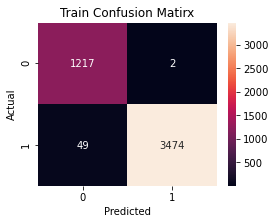

In [24]:
# Confusion matrix
cf = confusion_matrix(train_actual, train_pred)
fig = plt.figure(figsize = (4,3))
ax = fig.gca()
sn.heatmap(cf, annot=True,fmt='g')
plt.title('Train Confusion Matirx')
plt.xlabel('Predicted')
plt.ylabel('Actual')
fig.savefig(r"images/Train_ConfusionMatrix.png", format="png")

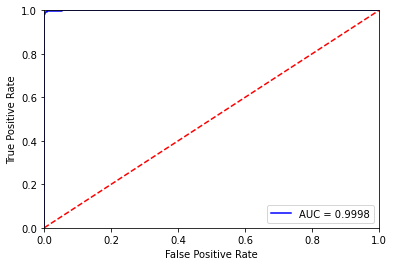

In [25]:
# ROC curve
fpr, tpr, _ = roc_curve(train_actual, train_pred_probs)
cnn_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % cnn_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
fig.savefig(r"images/Train_ROC_curve.png", format="png")

## Perfromance on Validation set

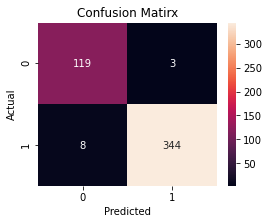

In [26]:
# Confusion matrix
cf = confusion_matrix(val_actual, val_pred)
fig = plt.figure(figsize = (4,3))
ax = fig.gca()
sn.heatmap(cf, annot=True,fmt='g')
plt.title('Confusion Matirx')
plt.xlabel('Predicted')
plt.ylabel('Actual')
fig.savefig(r"images/Val_ConfusionMatrix.png", format="png")

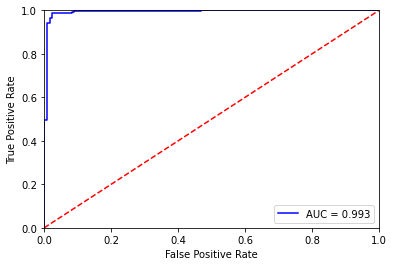

In [27]:
# ROC curve
fpr, tpr, _ = roc_curve(val_actual, val_pred_probs)
cnn_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % cnn_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
fig.savefig(r"images/Val_ROC_curve.png", format="png")

## Performance on Test set

In [28]:
test_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our test data
test_data_gen = test_image_generator.flow_from_directory(batch_size=params['batch_size'],
                                                          directory=test_dir,
                                                          shuffle=False,
                                                          target_size=(params['img_h'], params['img_w']),
                                                          color_mode='grayscale',
                                                          class_mode='binary')

Found 624 images belonging to 2 classes.


In [29]:
# Create arrays for y, y_hat and likelihoods
test_pred_probs = sigmoid(cnn_1.predict_generator(test_data_gen))
test_pred = (test_pred_probs > 0.5) * 1
test_actual = test_data_gen.classes.reshape(-1,1)

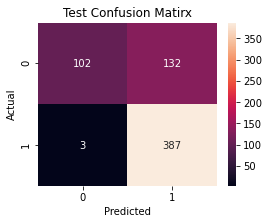

In [30]:
# Confusion matrix
cf = confusion_matrix(test_actual, test_pred)
fig = plt.figure(figsize = (4,3))
ax = fig.gca()
sn.heatmap(cf, annot=True,fmt='g')
plt.title('Test Confusion Matirx')
plt.xlabel('Predicted')
plt.ylabel('Actual')
fig.savefig(r"images/Test_ConfusionMatrix.png", format="png")

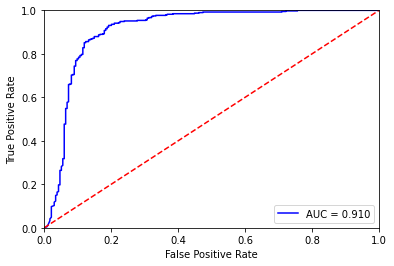

In [31]:
# ROC curve
fpr, tpr, _ = roc_curve(test_actual, test_pred_probs)
cnn_auc = auc(fpr, tpr)
fig = plt.figure()
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % cnn_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
fig.savefig(r"images/Test_ROC_curve.png", format="png")

In [32]:
print("Accuracy on the test set is %0.2f" %accuracy_score(test_actual, test_pred))

Accuracy on the test set is 0.78
